# __Parcours numérique - Projet ATMO__

Le projet, "**atmo**", s'inscrits dans le cadre de l'UE **Parcours numérique**. Notre objectif au sein de ce dernier est de parvenir à prédire les concentrations en Ozone (O3), sur l'année 2016 en se basant sur des relevés effectués par 74 stations sur toute l'année 2015. Nous pourrons ainsi déduire si une alerte aura lieu au jour **d+1**.

**Objectif :** Prédir le plus precisement possible chaque jours à midi s'il faudra lever une alerte de pollution le lendemain.

*(Tout au long du notebook, des fichiers `csv`, `pyobj` et `png` sont sauvegardés pour ne pas avoir à tout recalculer à chaque execution)*

Afin d'atteindre cet objectif, il est indispensable d'effectuer un "**nettoyage**" des données brutes obtenues par les stations. En effet, appliquer des algorithmes de résolution à un dataset de donnée brut conduiraient à des erreurs d'apprentissage. 

## __I. Nettoyage des données__
Nous disposons d'un fichier de données pour l'entrainement `Challenge_Data_O3_2015.rds` et d'un fichier de données pour l'évaluation des performances de nos prédictions `Challenge_Data_O3_2016.rds`.

A l'aide de la bibliothèque **pyreadr**, nous avons pu extraire toutes les données contenues dans les fichiers `xxx.rds`.

In [49]:
from pyreadr import read_r

TRAIN_DATA = read_r("Challenge_Data_O3_2015.rds")[None]
TEST_DATA = read_r("Challenge_Data_O3_2016.rds")[None]

Chaque ligne de ces fichiers représente une mesure de concentration d'ozone faite par une station à un instant donné.
Ces fichiers ont pour en-têtes :
- `Organisme`: l'identifiant de l'organisme gérant la station
- `Station`: l'identifiant de la station au sein de l'organisme
- `Mesure`: l'identifiant de la grandeur mesurée (ici toujours la même valeur correspondant à l'ozone)
- `Valeur`: la valeur de concentration mesurée
- `idPolair`: la concatenation des champs `Organisme` et `Station`
- `date`: la date à laquelle la mesure a été faite.

Pour éviter de manipuler des données redontantes, nous commençons par supprimer les colonnes `Organisme` et `Station` puisque leurs données sont déjà présentes dans la colonne `idPolair`, que nous renommons `station_id` pour plus de clareté.

De même, la colonne `Mesure` n'apportant pas d'information, nous la supprimons.

Pour plus de régularité, nous renommons la colonne `Valeur` en `value`.

Pour pouvoir gérer plus efficacement l'aspect temporel des donées, nous transformons la colonne `date` en `time` représentant le nombre d'heures écoulées depuis le début de l'année. Cela est possible car les capteurs ne relèvent au maximum qu'une mesure par heure, et cela nous permet de gérer plus efficacement les changements d'heures.

Enfin, nous ajoutons une colonne `alert` qui vaut `True` si une alerte est levée dans la journée, `False` sinon. Le seuil d'alerte est fixé à une concentration d'Ozone de **100 $µg/m^3$**

In [50]:
ALERT_THRESHOLD = 100

In [51]:
from pandas import DataFrame, to_datetime

def clean_data(data: DataFrame) -> DataFrame:
    data = data.copy()
    data = data.rename(columns={"idPolair": "station_id", "Valeur": "value"})

    data["date"] = to_datetime(data["date"], format="%Y-%m-%d %H")

    start_of_year = to_datetime(data["date"].dt.year.astype(str) + '-01-01 00:00:00')
    data["time"] = (data["date"] - start_of_year).dt.total_seconds() / 3600
    data["time"] = data["time"].astype(int)

    data["alert"] = data["value"] > ALERT_THRESHOLD

    data["day"] = data["date"].dt.date
    data["alert"] = data.groupby(["station_id", "day"])["alert"].transform("any")

    data = data.drop(columns=["Organisme", "Station", "Mesure", "date", "day"])

    return data

In [52]:
from pathlib import Path

TRANSFORMED_DATA_DIR = Path("transformed_data")
TRANSFORMED_DATA_DIR.mkdir(exist_ok=True, parents=True)

In [53]:
from pandas import read_csv

TRAIN_DATA_PATH = TRANSFORMED_DATA_DIR / "train_data.csv"
TEST_DATA_PATH = TRANSFORMED_DATA_DIR / "test_data.csv"

if not TRAIN_DATA_PATH.exists():
    TRAIN_DATA = clean_data(TRAIN_DATA)
    TRAIN_DATA.to_csv(TRAIN_DATA_PATH, index=False)
else:
    TRAIN_DATA = read_csv(TRAIN_DATA_PATH)

if not TEST_DATA_PATH.exists():
    TEST_DATA = clean_data(TEST_DATA)
    TEST_DATA.to_csv(TEST_DATA_PATH, index=False)
else:
    TEST_DATA = read_csv(TEST_DATA_PATH)

Une fois ce premier traîtement réalisé, le dataset de l'ensemble des données fournies par les stations de mesures prend la forme suivante : 

In [54]:
print(TRAIN_DATA)

        value  station_id  time  alert
0        13.0       15013     0  False
1        12.0       15013     1  False
2        28.0       15013     2  False
3        13.0       15013     3  False
4        30.0       15013     4  False
...       ...         ...   ...    ...
648235    NaN        7058  8755  False
648236    NaN        7058  8756  False
648237    NaN        7058  8757  False
648238    NaN        7058  8758  False
648239    NaN        7058  8759  False

[648240 rows x 4 columns]


## __II. Gestion des données manquantes__

A ce stade, nous remarquons que les données comportent plusieurs trous. Certaines stations ont de temps en temps arrété de transmettre des mesures durant des périodes allant de 1h à plusieurs mois. Cela est représenté dans les données par la présence de valeurs `NaN` dans la colonne `value`. Nous allons ainsi tenter plusieurs méthodes pour s'occuper de ces données manquantes.

### Méthode 1 : supprimer les données incomplètes

Une méthode simple consiste à supprimer les données comportant des `NaN`. Ainsi, seules les mesures ayant un réel impact seront conservées. Afin d'éviter les problèmes dues à l'entraînement des algorithmes sur un nombre de valeur trop faible, nous ne conserverons uniquement les stations ayant au moins l'équivalent de un mois de données.

In [55]:
def remove_missing_values(data: DataFrame) -> DataFrame:
    return data[data["value"].notna()].copy()

### Méthode 2 : remplacer les données incomplètes par la dernière valeur complète

Une autre méthode simple consiste à remplacer les données incomplètes par la dernière valeur valide. Cette méthode semble bien fonctionner pour des "trous" limités dans le temps (au maximum une journée par exemple), mais nous pouvons dors et déjà prédire que s'il manque plusieurs semaines / plusieurs mois de données consécutives, nous allons risquer de fortement biaiser notre modèle d'apprentissage. 

In [56]:
def fill_with_last(data: DataFrame) -> DataFrame:
    data["value"] = data.groupby("station_id")["value"].bfill().ffill() # Forward fill in case of
                                                                        # a station starting with nan values
    return remove_missing_values(data) # Removing missing values in case of a station with no value at all

### Méthode 3 : remplacer les données incomplètes par la prochaine valeur complète

On procède ici comme avec la méthode précédente mais en regardant dans l'autre sens. De la même manière que pour la méthode précédente, le risque de biais est très important en cas de gros manque de données.

In [57]:
def fill_with_next(data: DataFrame) -> DataFrame:
    data["value"] = data.groupby("station_id")["value"].ffill().bfill() # Backward fill in case of
                                                                        # a station ending with nan values
    return remove_missing_values(data) # Removing missing values in case of a station with no value at all

### Méthode 4 : modéliser les données avec une somme de sinus

Enfin, la quatrième méthode de modélisation a été déterminée par une analyse graphique des données contenues dans une station. En observant les données contenues dans cette dernière, on remarque que l'on peut grossièrement estimer les données à l'aide d'une somme de sinus de périodes :
- 2 ans
- 1 jour

Afin de mieux illustrer cette affirmation, nous avons tracé, sur la base de la station 20037 les deux fonctions sinusoïdales.

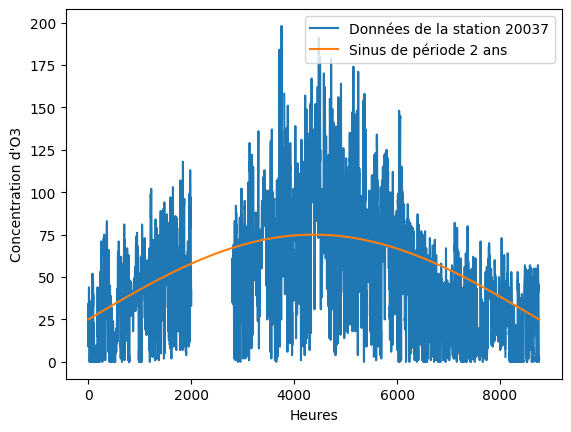

In [58]:
import matplotlib.pyplot as plt
from numpy import linspace, min, max, pi, sin

station_20037 = TRAIN_DATA[TRAIN_DATA["station_id"] == 20037]

plt.plot(station_20037["time"], station_20037["value"], label="Données de la station 20037")

x = linspace(min(station_20037["time"]), max(station_20037["time"]), 100)
plt.plot(x, 50 * sin(2 * pi / (2*365*24) * x) + 25, label="Sinus de période 2 ans")

plt.xlabel("Heures")
plt.ylabel("Concentration d'O3")
plt.legend()
plt.show()

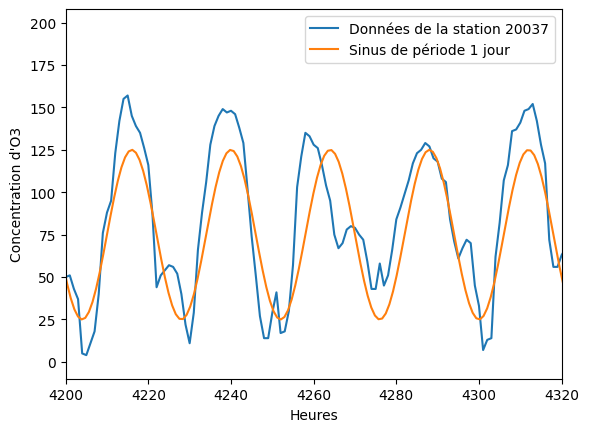

In [59]:
plt.plot(station_20037["time"], station_20037["value"], label="Données de la station 20037")

x = linspace(min(station_20037["time"]), max(station_20037["time"]), 10000)
plt.plot(x, 50 * sin(2 * pi / 24 * (x+14)) + 75, label="Sinus de période 1 jour")

plt.xlabel("Heures")
plt.ylabel("Concentration d'O3")
plt.xlim(4200, 4200 + 5*24)
plt.legend()
plt.show()

On cherche donc à modéliser nos données par une fonction de la forme

$
f(t) = A_1 sin(2 \pi f_{2 ans} t + \varphi_1) + A_2 sin(2 \pi f_{1 jour} t + \varphi_2) + b
$

In [60]:
from numpy import ndarray

W_2_YEARS = 2 * pi / (2 * 365 * 24)
W_1_DAY = 2 * pi / 24

def model_sinus(t: ndarray, A1: float, phi1: float, A2: float, phi2: float, b: float) -> ndarray:
    return A1 * sin(W_2_YEARS * t + phi1) + A2 * sin(W_1_DAY * t + phi2) + b

On ne peut cependant pas appliquer cette methode s'il manque trop de données. On choisit donc de ne garder que les stations ayant moins de 4 mois de trous sur l'année et on supprime les autres. 

In [61]:
from numpy import unique, where

STATION_KEEP_THRESHOLD = 4 # months
def get_station_id_with_enough_data(data: DataFrame) -> list[int]:
    id_stations_to_keep = []
    for id_station in unique(data["station_id"]):
        values = data[data["station_id"] == id_station]
        nan_indices = where(values["value"].isna())[0]

        nan_ratio = len(nan_indices) / len(values)

        if nan_ratio < (12 - STATION_KEEP_THRESHOLD) / 12:
            id_stations_to_keep.append(id_station)
    
    return id_stations_to_keep

Afin de déterminer les coefficients $A_1$, $\varphi_1$, $A_2$, $\varphi_2$ et $b$, on utilise une méthode des moindres carrés avec `scipy.optimize.curve_fit` par station.

In [62]:
from scipy.optimize import curve_fit

def fill_with_sin(data: DataFrame, plot: bool = False) -> DataFrame:
    for station_id in get_station_id_with_enough_data(data):
        station_values = data[data["station_id"] == station_id]

        nan_indices = where(station_values["value"].isna())[0]
        not_nan_indices = where(station_values["value"].notna())[0]

        if len(nan_indices) == 0:
            continue

        nan_values = station_values.iloc[nan_indices]
        not_nan_values = station_values.iloc[not_nan_indices]

        params, _ = curve_fit(model_sinus, not_nan_values["time"], not_nan_values["value"], maxfev=100_000)

        # Save data
        times = nan_values["time"]
        values = model_sinus(times, *params)
        data.loc[nan_values.index, "value"] = values

        if plot:
            plt.scatter(times, values, label="Données fittées sur le modèle de sinus", color="red", marker="+")

    return data[data["station_id"].isin(get_station_id_with_enough_data(data))].copy()


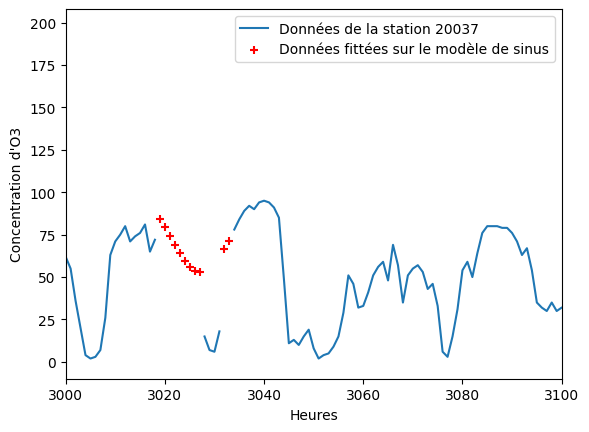

In [63]:
plt.plot(station_20037["time"], station_20037["value"], label="Données de la station 20037")
fill_with_sin(station_20037.copy(), True)

plt.xlabel("Heures")
plt.ylabel("Concentration d'O3")
plt.xlim(3000, 3100)
plt.legend()
plt.show()

On voit ici que le fit n'est pas parfait, mais est plutôt cohérent avec les données mesurées.

Cependant, quand la durée de données manquante est trop grande, le modèle ne retrace que les évolutions globales.

Par exemple sur cette même station sur la plage d'heure [2050, 2800], nous n'avons aucune donnée. Cette méthode appliquée à cette plage de données ne permet donc pas de retracer les évolutions locales de la concentration d'O3 comme le montre le schéma suivant : 

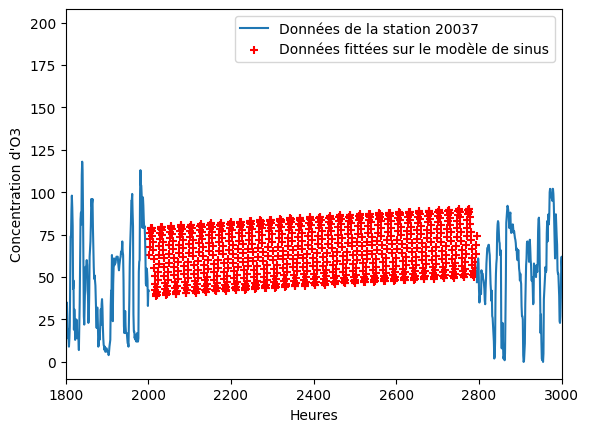

In [64]:
plt.plot(station_20037["time"], station_20037["value"], label="Données de la station 20037")
fill_with_sin(station_20037.copy(), True)

plt.xlabel("Heures")
plt.ylabel("Concentration d'O3")
plt.xlim(1800, 3000)
plt.legend()
plt.show()

---

On a ainsi 4 méthodes de nettoyage des données utilisables pour l'apprentissage de nos algorithmes.

In [65]:
CLEANING_METHODS = (
    remove_missing_values,
    fill_with_last,
    fill_with_next,
    fill_with_sin,
)

## __III. Prédiction des alertes__

On cherche maintenant à prédire, pour chaque jour à midi,  si une alerte devra être levée le lendemain tout en connaissant les mesures des heures précédentes.

In [66]:
from itertools import product

def iter_hours(count: int):
    if count < 2:
        raise ValueError("count must be greater than 1")
    
    ranges = []
    for i in range(1, count):
        ranges.append(range(i, 24 * (i-1) + 12 + 1))

    for values in product(*ranges):
        if all(earlier < later for earlier, later in zip(values, values[1:])):
            yield (0,) + tuple(-v for v in values)

Après avoir effectué une première étude en utiilisant des scoring du type `accuracy` ou `MSE`, nous avons remarqué que notre programme ne se contentait que de répondre qu'il n'y avait pas d'alerte avec l'algorithme Knn. La matrice de confusion alors obtenue est présentée ci après.

![fill_with_previous-KNeighborsClassifier.webp](attachment:fill_with_previous-KNeighborsClassifier.webp)

Cela est du au fait que le nombre d'alerte réelle est très important vis à vis du nombre total de test. Ainsi, avec un scoring se basant sur la précision du modèle voir même pour sa précision au carré, un paramètre simple et optimal est donc un paramètre répondant "non" à chaque requète. 

De ce fait, il faut donc utiliser un score ne dépendant pas essentiellement de la précision du programme. Nous avons donc choisi d'axer notre choix sur le nombre de faux positifs et de faux négatifs retourné par notre programme. 

Pour l'évaluation lors de la cross validation, on utilise la méthode de scoring `f1`, qui se calcule de la façon suivante :

$$
F1 = \frac{2 TP}{2 TP + FP + NF}
$$

où 
\begin{cases}
    TP : \text{Vrai positifs}\\
    FP : \text{Faux positifs}\\
    NF : \text{Faux négatifs}
\end{cases}

Cette méthode permet d'essayer de minimiser à la fois les faux positifs et les faux négatifs.

In [67]:
from typing import Any, Literal, Self
from numpy import isnan
from sklearn.base import ClassifierMixin, RegressorMixin
from sklearn.metrics import confusion_matrix as get_confusion_matrix
from sklearn.model_selection import GridSearchCV


type ClassifierOrRegressor = ClassifierMixin | RegressorMixin

FORMATTED_DATA_DIR = TRANSFORMED_DATA_DIR / "formatted_data"
FORMATTED_DATA_DIR.mkdir(exist_ok=True, parents=True)

class Estimator[T: ClassifierOrRegressor]:

    def __init__(self, estimator_class: type[T], cross_validation_params: dict[str, Any], input_features_count: int) -> None:
        self.estimator_class = estimator_class
        self.is_regressor = estimator_class.__name__.endswith("Regressor")
        self.cross_validation_params = cross_validation_params
        self.input_features_count = input_features_count

        self.best_score = {}
        self.best_params = {}
        self.best_estimator = {}
    
    def get_formatted_dataset(self, data: DataFrame, data_name: str, hours: tuple[Literal[0], int, ...]) -> DataFrame:
        # Returns saved file if it exists
        filepath = FORMATTED_DATA_DIR / f"{data_name}_{("_".join(str(hour) for hour in hours)).replace("-", "")}.csv"
        if filepath.exists():
            print(f" - Loading formatted data {hours}")
            return read_csv(filepath)
        print(f" - Computing formatted data {hours}")

        # Compute start time
        hour_offset = min(hours)
        min_time = 0
        max_time = max(data["time"])
        start_time = 12

        while start_time - hour_offset < min_time:
            start_time += 24

        # Build new DataFrame
        columns = list(data.columns)
        columns.remove("time")
        columns.remove("value")
        columns.remove("alert")
        for hour in hours:
            columns.append(f"time_h{hour}")
            columns.append(f"value_h{hour}")
        columns.append("alert_d+1")
        columns.append("value_d+1")

        new_data = DataFrame(columns=columns)

        # Iter over stations
        for station_id in unique(data["station_id"]):
            current_time = start_time - 24
            station_data = data[data["station_id"] == station_id]

            while current_time <= max_time:
                current_time += 24

                row_h0 = station_data[station_data["time"] == current_time]

                if len(row_h0["station_id"].values) == 0:
                    continue

                new_row = [
                    row_h0["station_id"].values[0],
                ]

                for hour in hours:
                    row_h_plus_hour = station_data[station_data["time"] == current_time - hour]

                    if (
                           len(row_h_plus_hour["time"].values) == 0
                        or len(row_h_plus_hour["value"]) == 0
                        or isnan(row_h_plus_hour["value"].values[0])
                    ):
                        break
    
                    new_row += [
                        row_h_plus_hour["time"].values[0],
                        row_h_plus_hour["value"].values[0],
                    ]
                else:
                    row_d_plus_1 = station_data[station_data["time"] == current_time + 24]
                    if len(row_d_plus_1["value"].values) == 0:
                        continue
                    new_row += [
                        row_d_plus_1["alert"].values[0],
                        row_d_plus_1["value"].values[0],
                    ]

                    new_data.loc[len(new_data)] = new_row

        # Save new DataFrame
        new_data.to_csv(filepath, index=False)
        return new_data

    def fit(self, train_data: DataFrame, data_name: str) -> Self:
        for station_id in unique(train_data["station_id"]):
            print(f" - Fitting model for station {station_id}")
            best_score = 0
            best_params = None
            best_estimator = None
            for hours in iter_hours(self.input_features_count):
                input_features = [
                    f"time_h{hour}"
                    for hour in hours
                ] + [
                    f"value_h{hour}"
                    for hour in hours
                ]

                data = self.get_formatted_dataset(train_data, data_name, hours)
                data = data[data["station_id"] == station_id]

                x = data[input_features].to_numpy()
                if self.is_regressor:
                    y = data["value_d+1"].to_numpy()
                else:
                    y = data["alert_d+1"].to_numpy()

                grid_search = GridSearchCV(self.estimator_class(), self.cross_validation_params, scoring="f1", cv=5, n_jobs=-1)
                print(f"   > Fitting with {len(y)} values")
                grid_search.fit(x, y)

                if grid_search.best_score_ > best_score:
                    best_score = grid_search.best_score_
                    best_params = grid_search.best_params_
                    best_params.update({"hours": hours})
                    best_estimator = grid_search.best_estimator_

            self.best_score[station_id] = best_score
            self.best_params[station_id] = best_params
            self.best_estimator[station_id] = best_estimator

        return self

    def get_confusion_matrix(self, test_data: DataFrame, data_name: str) -> ndarray:
        hours = self.best_params["hours"]
        
        data = self.get_formatted_dataset(test_data, data_name, hours)

        input_features = [
            f"time_h{hour}"
            for hour in hours
        ] + [
            f"value_h{hour}"
            for hour in hours
        ]

        x = data[input_features].to_numpy()
        y = data["alert_d+1"].to_numpy()

        y_pred = self.best_estimator.predict(x)
        if self.is_regressor:
            y_pred = y_pred > 100

        return get_confusion_matrix(y, y_pred)

In [68]:
ESTIMATOR_METHODS: list[tuple[ClassifierOrRegressor, dict[str, Any], int]] = []

### Méthode 1 : KNN Classifier

On entraîne ici une KNN par station, décidant si une alerte doit être levée le lendemain ou non. Pour éviter le problème de *curse of dimensionality*, on choisira comme input feature pour le KNN les temps et valeurs à h0, h-$a$ et h-$b$, avec $a$ et $b$ deux hyperparamètre, se limitant ainsi à un problème de dimension 6.

On a comme hyperparamètres :
- `n_neighbors` : le nombre de voisins à regarder que l'on choisira dans $\{3; 5; 7; 9; 11\}$
- `weights` : choisi si l'on normalise les données ou non ($\in \{\text{uniform; distance}\}$)
- `metric` : la distance utilisée $\in \{\text{chebyshev; minkowski}\}$ (la norme de Minkowski avec le paramètre $p$ à 1 et 2 est respectivement égale à la norme de manhattan et euclidienne)
- `p` : le paramètres pour la norme de Minkowski $\in [| 1; 3 |]$
- `a` : le paramètre que nous avons introduit
- `b` : cf `a` 

In [69]:
from sklearn.neighbors import KNeighborsClassifier

ESTIMATOR_METHODS.append((
    KNeighborsClassifier,
    {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "metric": ["chebyshev", "minkowski"],
        "p": [1, 2, 3],
    },
    3,
))

## __IV. Entraînement__

Après avoir mis en forme les données, effectué un nettoyage de ces dernières afin de limiter les perturbations occasionnées par des données brutes sur l'entraînement des algorithmes et enfin la définition de ces derniers, il est désormais temps de passer à la phase d'entraînement de ces six alogithmes. 

Nous allons tester chacune des méthodes de nettoyage sur chacune des méthodes de prédiction afin de ne retenir que le meilleur combot.

In [70]:
CLEANED_DATA_DIR = TRANSFORMED_DATA_DIR / "cleaned_data"
CLEANED_DATA_DIR.mkdir(exist_ok=True, parents=True)

ESTIMATORS_DIR = Path("estimators")
ESTIMATORS_DIR.mkdir(exist_ok=True, parents=True)

CONFUSION_MATRICES_DIR = Path("confusion_matrices")
CONFUSION_MATRICES_DIR.mkdir(exist_ok=True, parents=True)


In [71]:
from pickle import dump as save_python_object
from pickle import load as load_python_object
from sklearn.metrics import ConfusionMatrixDisplay

for cleaning_method, (estimator_class, cross_validation_params, input_features_count) in product(CLEANING_METHODS, ESTIMATOR_METHODS):
    cleaning_method_name = cleaning_method.__name__
    estimation_method_name = estimator_class.__name__

    print(f"Computing {cleaning_method_name} {estimation_method_name}")

    # Clean data
    cleaned_data_filepath = CLEANED_DATA_DIR / f"{cleaning_method_name}.csv"
    if cleaned_data_filepath.exists():
        print("- Loading cleaned data")
        cleaned_data = read_csv(cleaned_data_filepath)
    else:
        print("- Computing cleaned data")
        cleaned_data = cleaning_method(TRAIN_DATA)
        cleaned_data.to_csv(cleaned_data_filepath, index=False)
    
    # Fit estimator
    estimator_filepath = ESTIMATORS_DIR / f"estimator_{estimation_method_name}.pyobj"
    if estimator_filepath.exists():
        print("- Loading estimator")
        estimator = load_python_object(estimator_filepath)
    else:
        print("- Computing estimator")
        estimator = Estimator(estimator_class, cross_validation_params, input_features_count)
        estimator.fit(cleaned_data, cleaning_method_name)
        save_python_object(estimator, estimator_filepath)
    
    # Save confusion matrix
    print("- Computing confusion matrix")
    confusion_matrix = estimator.get_confusion_matrix(TEST_DATA, "TEST_DATA")
    confusion_matrix_filepath = CONFUSION_MATRICES_DIR / f"{cleaning_method_name}_{estimation_method_name}.png"

    plt.figure()
    display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=("Pas d'Alerte", "Alerte"))
    display.plot(cmap=plt.cm.Blues)
    plt.title(f"{cleaning_method_name} : {estimation_method_name}")
    plt.savefig(confusion_matrix_filepath)
    plt.show()


Computing remove_missing_values KNeighborsClassifier
- Loading cleaned data
- Computing estimator
 - Fitting model for station 7001
 - Loading formatted data (0, -1, -2)
   > Fitting with 357 values
 - Loading formatted data (0, -1, -3)
   > Fitting with 357 values
 - Loading formatted data (0, -1, -4)
   > Fitting with 357 values
 - Loading formatted data (0, -1, -5)
   > Fitting with 356 values
 - Loading formatted data (0, -1, -6)
   > Fitting with 357 values
 - Loading formatted data (0, -1, -7)
   > Fitting with 357 values
 - Loading formatted data (0, -1, -8)
   > Fitting with 357 values
 - Loading formatted data (0, -1, -9)
   > Fitting with 357 values
 - Loading formatted data (0, -1, -10)
   > Fitting with 357 values
 - Loading formatted data (0, -1, -11)
   > Fitting with 357 values
 - Loading formatted data (0, -1, -12)
   > Fitting with 357 values
 - Loading formatted data (0, -1, -13)
   > Fitting with 357 values
 - Loading formatted data (0, -1, -14)
   > Fitting with 356

KeyboardInterrupt: 